## 1 - PPO on Atari PongDeterministic-v4

In [0]:
# 1 - Install and import required files
# !pip install keras-gym -U
import gym
import keras_gym as km
from tensorflow.keras.layers import Conv2D, Lambda, Dense, Flatten
from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# 2 - Pre processing
env = gym.make('PongDeterministic-v4')
env = km.wrappers.ImagePreprocessor(env, height=105, width=80, grayscale=True)
env = km.wrappers.FrameStacker(env, num_frames=3)
env = km.wrappers.TrainMonitor(env)

# 3 - show logs from TrainMonitor
km.enable_logging()

# 4 - Function approximator method
class FunctionApprox(km.FunctionApproximator):
    def body(self, S):
        def diff_transform(S):
            S = K.cast(S, 'float32') / 255
            M = km.utils.diff_transform_matrix(num_frames=3)
            return K.dot(S, M)

        X = Lambda(diff_transform)(S)
        X = Conv2D(filters=16, kernel_size=8, strides=4, activation='relu')(X)
        X = Conv2D(filters=32, kernel_size=4, strides=2, activation='relu')(X)
        X = Flatten()(X)
        X = Dense(units=256, activation='relu')(X)
        return X

# 5 - Function approximator params
params = FunctionApprox(env, lr=0.00025)
pi = km.SoftmaxPolicy(params, update_strategy='ppo')
v = km.V(params, gamma=0.99, bootstrap_n=10, bootstrap_with_target_model=True)
actor_critic = km.ActorCritic(pi, v)
total_rewards_list_env1 = []
total_reward = 0

# 6 - Replay buffer
buffer = km.caching.ExperienceReplayBuffer.from_value_function(
    value_function=v, capacity=256, batch_size=64)


# 7 - Execution of episodes and result
while env.T < 50000:
    current_episode = env.reset()

    # 7.1 - Execution
    for t in range(env.spec.max_episode_steps):
        a = pi(current_episode, use_target_model=True)  # target_model == pi_old
        next_episode, reward, terminate, data = env.step(a)
        total_reward += reward
        total_rewards_list_env1.append(total_reward)

        buffer.add(current_episode, a, reward, terminate, env.ep)

        if len(buffer) >= buffer.capacity:
            # use 4 epochs per round
            num_batches = int(4 * buffer.capacity / buffer.batch_size)
            for _ in range(num_batches):
                actor_critic.batch_update(*buffer.sample())
            buffer.clear()
            actor_critic.sync_target_model(tau=0.1)

        if terminate:
            break

        current_episode = next_episode

    # 7.2 - Generate result
    if env.ep % 50 == 0:
        km.utils.generate_gif(
            env=env,
            policy=pi,
            filepath='./data/ppo/gifs/ep{:06d}.gif'.format(env.ep),
            resize_to=(320, 420))

INFO:TrainMonitor:ep: 1, T: 1,026, G: -20, avg_G: -20, t: 1025, dt: 16.617ms, loss: 0.247, policy/entropy: 1.79, policy/kl_div: 0.00448, policy/loss: 0.0606, value/loss: 0.0931
INFO:TrainMonitor:ep: 2, T: 2,062, G: -21, avg_G: -20.5, t: 1035, dt: 14.591ms, loss: 0.177, policy/entropy: 1.79, policy/kl_div: 0.00199, policy/loss: 0.0165, value/loss: 0.0803
INFO:TrainMonitor:ep: 3, T: 2,827, G: -21, avg_G: -20.7, t: 764, dt: 14.540ms, loss: 0.172, policy/entropy: 1.79, policy/kl_div: 0.00271, policy/loss: 0.00374, value/loss: 0.0842
INFO:TrainMonitor:ep: 4, T: 3,819, G: -19, avg_G: -20.2, t: 991, dt: 14.968ms, loss: 0.14, policy/entropy: 1.79, policy/kl_div: 0.00483, policy/loss: -0.00759, value/loss: 0.0739
INFO:TrainMonitor:ep: 5, T: 4,674, G: -21, avg_G: -20.4, t: 854, dt: 13.649ms, loss: 0.128, policy/entropy: 1.79, policy/kl_div: 0.00362, policy/loss: -0.00982, value/loss: 0.0691
INFO:TrainMonitor:ep: 6, T: 5,868, G: -19, avg_G: -20.2, t: 1193, dt: 15.568ms, loss: 0.123, policy/entrop


 Total Loss List Graph:


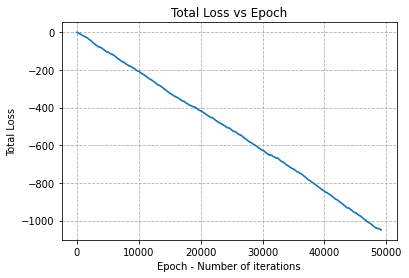

In [0]:
print('\n Total Loss List Graph:')
plt.plot(total_rewards_list_env1)
plt.title("Total Loss vs Epoch")
plt.xlabel('Epoch - Number of iterations')
plt.ylabel('Total Loss')
plt.grid(ls='--')
plt.show()

## 2 - DQN on PongDeterministic-v4

In [0]:
# 1 - Install and import required files
# !pip install keras-gym -U
import gym
import keras_gym as km
from tensorflow.keras.layers import Conv2D, Lambda, Dense, Flatten
from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# 2 - Pre processing
env = gym.make('PongDeterministic-v4')
env = km.wrappers.ImagePreprocessor(env, height=105, width=80, grayscale=True)
env = km.wrappers.FrameStacker(env, num_frames=3)
env = km.wrappers.TrainMonitor(env)

# 3 - show logs from TrainMonitor
km.enable_logging()

# 4 - Function approximator method
class FunctionApprox(km.FunctionApproximator):
    def body(self, S):
        def diff_transform(S):
            S = K.cast(S, 'float32') / 255
            M = km.utils.diff_transform_matrix(num_frames=3)
            return K.dot(S, M)

        X = Lambda(diff_transform)(S)
        X = Conv2D(filters=16, kernel_size=8, strides=4, activation='relu')(X)
        X = Conv2D(filters=32, kernel_size=4, strides=2, activation='relu')(X)
        X = Flatten()(X)
        X = Dense(units=256, activation='relu')(X)
        return X

# 5 - Function approximator params
params = FunctionApprox(env, lr=0.00025)
q = km.QTypeII(
    function_approximator=params,
    gamma=0.99,
    bootstrap_n=1,
    bootstrap_with_target_model=True)

# 6 - Replay buffer and policy
buffer = km.caching.ExperienceReplayBuffer.from_value_function(
    value_function=q,
    capacity=10000,
    batch_size=32)
policy = km.EpsilonGreedy(q)

# 7 -Update schedule
buffer_warmup_period = 500
target_model_sync_period = 100

# 8 - Exploration
def epsilon(T):
    M = 1000
    if T < M:
        return 1 - 0.9 * T / M
    if T < 2 * M:
        return 0.1 - 0.09 * (T - M) / M
    return 0.01

total_rewards_list_env2 = []
total_reward = 0


# 9 - Execution of episodes and result
while env.T < 30000:
    current_episode = env.reset()

    # 9.1 - Execution
    for t in range(env.spec.max_episode_steps):
        policy.epsilon = epsilon(env.T)
        action = policy(current_episode)
        next_episode, reward, done, data = env.step(action)
        total_reward += reward
        total_rewards_list_env2.append(total_reward)

        buffer.add(current_episode, action, reward, done, env.ep)

        if env.T > buffer_warmup_period:
            q.batch_update(*buffer.sample())

        if env.T % target_model_sync_period == 0:
            q.sync_target_model()

        if done:
            break

        current_episode = next_episode

    # 9.2 - Generate result
    if env.ep % 10 == 0 and env.T > buffer_warmup_period:
        km.utils.generate_gif(
            env=env,
            policy=policy.set_epsilon(0.01),
            filepath='./data/dqn/gifs/ep{:06d}.gif'.format(env.ep),
            resize_to=(320, 420))


INFO:TrainMonitor:ep: 1, T: 1,007, G: -21, avg_G: -21, t: 1006, dt: 31.255ms, loss: 0.00722
INFO:TrainMonitor:ep: 2, T: 1,878, G: -20, avg_G: -20.5, t: 870, dt: 56.216ms, loss: 0.0032
INFO:TrainMonitor:ep: 3, T: 2,643, G: -21, avg_G: -20.7, t: 764, dt: 56.561ms, loss: 0.00175
INFO:TrainMonitor:ep: 4, T: 3,468, G: -21, avg_G: -20.8, t: 824, dt: 56.539ms, loss: 0.00217
INFO:TrainMonitor:ep: 5, T: 4,295, G: -21, avg_G: -20.8, t: 826, dt: 56.434ms, loss: 0.00263
INFO:TrainMonitor:ep: 6, T: 5,347, G: -20, avg_G: -20.7, t: 1051, dt: 56.485ms, loss: 0.00299
INFO:TrainMonitor:ep: 7, T: 6,331, G: -20, avg_G: -20.6, t: 983, dt: 56.636ms, loss: 0.00405
INFO:TrainMonitor:ep: 8, T: 7,331, G: -18, avg_G: -20.2, t: 999, dt: 56.200ms, loss: 0.00345
INFO:TrainMonitor:ep: 9, T: 8,202, G: -20, avg_G: -20.2, t: 870, dt: 56.537ms, loss: 0.00352
INFO:TrainMonitor:ep: 10, T: 9,151, G: -19, avg_G: -20.1, t: 948, dt: 56.476ms, loss: 0.00322
INFO:TrainMonitor:ep: 11, T: 9,944, G: -21, avg_G: -20.2, t: 792, dt: 


 Total Loss List Graph:


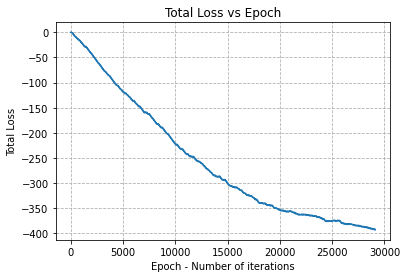

In [0]:
print('\n Total Loss List Graph:')
plt.plot(total_rewards_list_env2)
plt.title("Total Loss vs Epoch")
plt.xlabel('Epoch - Number of iterations')
plt.ylabel('Total Loss')
plt.grid(ls='--')
plt.show()